## Problem 1 Poisson equation (Sparse matrices)

## 50 pts

Consider a 2D Poisson equation
$$
\Delta u \equiv \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f, \quad (x,y)\in [0,1]^2
$$ 
with following boundary conditions
$$
u\big|_{x=0} = 0, \quad  u\big|_{x=1} = 0, \quad u\big|_{y=0} = 0, \quad u\big|_{y=1} = 0,
$$
with known function $f(x,y)$ and unknown $u(x,y)$.

To find solution of the Poisson equation we will use the **finite difference method**. Standard second order finite difference discretization on a uniform grid $(x_i, y_j) = (ih, jh)$, $i,j = 0,\dots, N$, $h = \frac{1}{N}$ leads to the following system of equations:
$$
\begin{split}
   &\frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h^2} + \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h^2} = f(ih,jh) \\
   &u_{0,j} = u_{i,0} = u_{N,j} = u_{i,N} = 0, \quad i,j = 1,\dots,N
\end{split}
$$

* Check that this system can be written in a matrix form
$$
A_h u_h = f_h,
$$
where 
$$u_h = (u_{1,1},\dots, u_{1,N-1} , u_{2,1},\dots, u_{2,N-1}, \dots, u_{N-1,1},\dots, u_{N-1,N-1})^T$$
$$f_h = (f_{1,1},\dots, f_{1,N-1} , f_{2,1},\dots, f_{2,N-1}, \dots, f_{N-1,1},\dots, f_{N-1,N-1})^T$$
and
$$ A_h = I\otimes a_h + a_h \otimes I, \quad a_h = \frac{1}{h^2}\mathrm{tridiag\left( 1,-2,1\right)},$$
where $\otimes$ denotes [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product).



* Choose $f(x,y)$ such that $u(x, y) = \sin\pi x \sin \pi y$ is a solution (just substitute $u$ in the Poisson equation and find $f$, then pretend as if you do not know the solution $u$ :)).


* Assemble matrix $A_h$ in the `CSR` format using functions from the `scipy.sparse` package (functions `scipy.sparse.kron` and `scipy.sparse.spdiags` might be helpful). <font color='red'> Do not use full matrices! Use only sparse arithmetics </font>


* Solve the system using the `scipy.sparse.linalg.spsolve` and make sure that you get solution close to the $u(x, y) = \sin\pi x \sin \pi y$ (the bigger $N$ you take, the closer to the $u(x, y) = \sin\pi x \sin \pi y$ you must be).


* Run `cg`, `minres`, `GMRES`, `BicgStab` iterative methods for this system for $N=256$ and make plots of residual w.r.t. number of iterations on one plot. Do not forget to provide label names. 


* What is the method of choice among `cg`, `minres`, `GMRES`, `BicgStab` for this problem? Why? Name advantages and disadvantages of these methods.


* Solve the system via an appropriate Krylov method with and without ILU preconditioner (play with different ILU preconditioners and find the one with the smallest number of iterations for this particular problem). To illustrate your answer plot residuals for different ILU preconditioners on one plot. Do you think that less iterations will give you reduced calculation time?


* **Bonus:** Find analytically eigenvalues of the matrix $A_h$ and prove that $\text{cond}( A_h )= \mathcal{O}\left(\frac{1}{h^2}\right)$

$A_h u_h = f_h$ => $(I\otimes a_h + a_h \otimes I)(u_{1,1},\dots, u_{1,N-1} , u_{2,1},\dots, u_{2,N-1}, \dots, u_{N-1,1},\dots, u_{N-1,N-1})^T =(f_{1,1},\dots, f_{1,N-1} , f_{2,1},\dots, f_{2,N-1}, \dots, f_{N-1,1},\dots, f_{N-1,N-1})^T$ 

$I\otimes a_h*vec(u(ih,jh)) + a_h \otimes I*vec(u(ih,jh))= vec(f(ih,jh))$ => vec(I * a_h*u(ih,jh)+a_h*I*u(ih,jh))= vec(f(ih,jh))$ 

$I*a_h*u(ih,jh)+a_h*I*u(ih,jh)= f(ih,jh)$ 

where $a_h = \frac{1}{h^2}\mathrm{tridiag\left( 1,-2,1\right)}$

$ \frac{u_{i,j+1} - 2u_{i,j} + u_{i,j-1}}{h^2} + \frac{u_{i+1,j} - 2u_{i,j} + u_{i-1,j}}{h^2}  = f(ih,jh)$

$\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} = f$

$u(x, y) = \sin\pi x \sin \pi y$

$\frac{\partial^2 u}{\partial x^2} = -\pi^2\sin\pi x \sin\pi y$

$\frac{\partial^2 u}{\partial y^2} = -\pi^2\sin\pi x \sin\pi y$

$f =  -2 \pi^2\sin\pi x \sin\pi $

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as linalg

def x(n):
    grid = np.linspace(0,1,n)
    x, y = np.meshgrid(grid, grid, sparse="True")
    return np.sin(np.pi*x)*np.sin(np.pi*y)

def f(n):
    grid_rhs = np.linspace(0 + 1./(n-1), 1 - 1./(n-1), n-2).reshape(n-2,1)
    x, y = np.meshgrid(grid_rhs, grid_rhs,sparse="True")
    rhs = -2*(np.pi**2)*np.sin(np.pi*x)*np.sin(np.pi*y) 
    return rhs.flatten() 

def a_t(n):
    diags = np.array([0,-1,1])
    diagdata = np.array([[-2]*(n), [1]*(n), [1]*(n)])
    return sp.spdiags(diagdata, diags, n, n, 'csr')

def A(n):
    I = sp.eye(n-2)    
    A = sp.kron(a_t(n-2),I)+sp.kron(I,a_t(n-2))
    A = csr_matrix(A)*(n-1)**2
    return A 


/Users/Toma/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


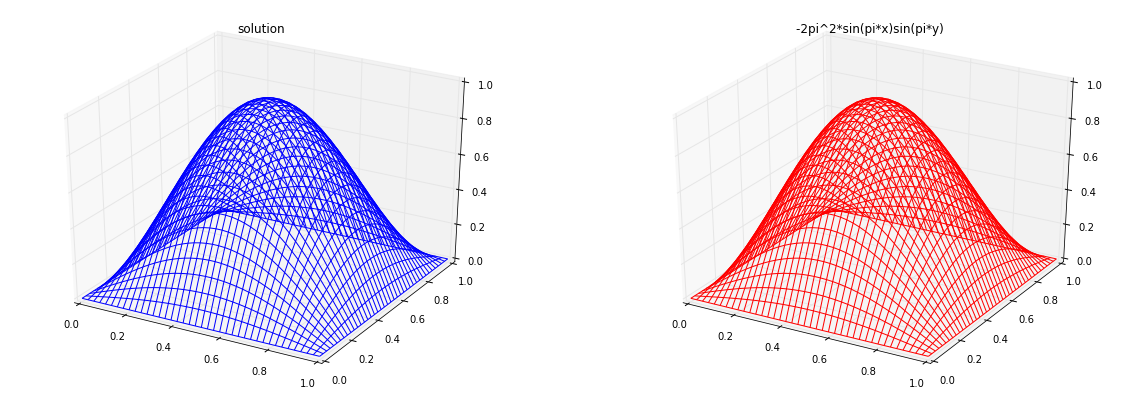

norm  0.0105478711172


In [2]:
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

n=40
x_real = x(n)

solution = linalg.spsolve(A(n), f(n))
solution = np.reshape(solution, (n-2, n-2))
result = np.zeros((n,n))
result[1:-1,1:-1] = solution


i, j = np.meshgrid(np.linspace(0,1,n), np.linspace(0,1,n), sparse="True")
fig = pl.figure(figsize=(20,15))
ax = fig.add_subplot(223, projection='3d')
ax.plot_wireframe(i,j,result)
ax.set_title('solution')
ax = fig.add_subplot(224, projection='3d')
ax.plot_wireframe(i,j, x_real,color='r') 
ax.set_title('-2pi^2*sin(pi*x)sin(pi*y) ')
pl.show()
print 'norm ',np.linalg.norm(x_real - result)

cg:
+ pseudo iterative, needs less memory, requires less krylov basis vectors, gives exact solution at n iterations
- matrix have to be SPD matrix and sometimes for just symmetric, does not work for the non-symmetric matrices, could be unstable compared to Gaussian elimination

minres:
+ matrix could not be positive definite
- doesn't support in python, matrix must be symmetric

gmres: 
+ works for non-symmetric matrices
- needs more memory than cg and memory costs grows with each step, requires more iterations, pure iterative, buggy realization for mac os, finds approximate solution x


bicgstab:
+ works for non-symmetric matrices + everything from cg
- everything from cg

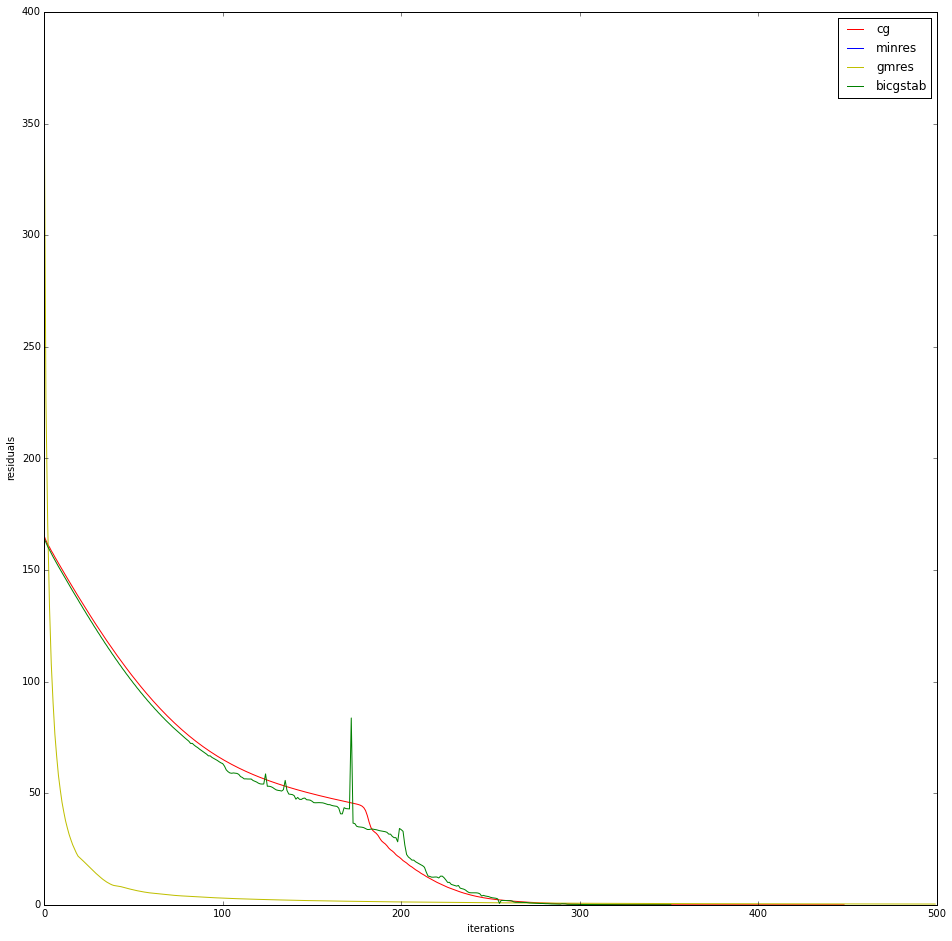

In [5]:
import time
import sys
import scipy
import numbers

n = 256
AA = A(n)
ff = f(n)
x0 = np.ones(ff.shape) # np.random.random(ff.shape)
x_real = x(n).reshape(-1)

i = 0
normlist = []

def callback(xk):
    global i, normlist, n, x_real
    i=i+1
    x = np.reshape(xk, (n-2, -1))
    sol= np.zeros((n,n))
    sol[1:-1,1:-1] = x
    normlist.append(np.linalg.norm(x_real-sol.reshape(-1)))
    
def callback_gmres(xk):
    global i, normlist, n
    i=i+1
    normlist.append(xk)

pl.figure(figsize=(16,16))
pl.xlabel("iterations")
pl.ylabel("residuals")

sol = linalg.cg(AA, ff,x0,callback=callback)
pl.plot(range(i),normlist,'r', label = 'cg')

i = 0
normlist = []
sol = linalg.minres(AA, ff,x0,callback=callback)
pl.plot(range(i),normlist,'b', label = 'minres')


i = 0
normlist = []
linalg.gmres(AA, ff,x0,callback=callback_gmres)
pl.plot(range(500),normlist[0:500],'y', label = 'gmres')


i = 0
normlist = []
linalg.bicgstab(AA, ff,x0,callback=callback)
pl.plot(range(i),normlist,'g', label = 'bicgstab')

pl.legend()
pl.show()

It's obvious that scipy.sparse.linalg.minres doesn't support anymore. Minimum number of iterations was in bicgstab method. However, the most significant drop of residual was showed by gmres method. I'll pick gmres as best one. 

In [ ]:
import random
fill_list = np.linspace(0.1, 1.0, num=10)
color_list = ['r','g','y','b',]
pl.figure(figsize=(16,10))
for i in fill_list:
    P = scipy.sparse.linalg.spilu(AA, fill_factor=i)
    lo = scipy.sparse.linalg.LinearOperator(AA.shape, lambda x: P.solve(x))
    i = 0
    normlist = []
    linalg.gmres(AA, ff,x0,M=lo,callback=callback_gmres)
    color = "#"+("%06x"%random.randint(0,16777215))
    pl.plot(range(i),normlist,color, label = 'lm=%s'%i)
    
pl.show()
# 1.0 is the best. Time is the same for all lm.

## Problem 2 Deconvolution (Structured matrices)

## 50 pts + 30 pts

In the problem set 2 you were asked to find convolution of the Lena image with the following filter
$$
T_{i_1j_1i_2j_2} \equiv T_{i_1-j_1,i_2-j_2} = \frac{\alpha}{\pi} e^{-\alpha \left[(i_1 - j_1)^2 + (i_2 - j_2)^2 \right]}, \quad i_1,j_1, i_2, j_2 = 1,\dots, n, \quad \alpha = \frac{1}{50}
$$

* Write matvec function that produces multiplication of $T$ by a given vector $x$. Use `scipy.sparse.linalg.LinearOperator` to create an object that has attribute `.dot()` (this object will be further used in the iterative process). Note that `.dot()` input and output must be 1D vectors, so the function `np.reshape` will be usefull.


* Convolve Lena with $T$ for $\alpha = \frac{1}{100}$ using the obtained Linear Operator. Plot the result as an image.


* Run an appropriate Krylov method with the obtained Linear Operator and try to reconstruct Lena using the right hand side from the previous bullet (smoothed Lena). Plot norm of residual with respect to the number of iterations for different $\alpha$ and corresponding right hand side. Comment on the results.

Find image with your name in the attached to this problem set file. This image is the convolution with $T$ for $\alpha=\frac{1}{15}$ with small random noise:
<img src='noise.png' width=300>

The original image looks like
<img src='orig.png'>

It contains 3 code lines (e.g. yOu, ArE, aWEs0me).
Your goal now is to recognize these 3 codes. Each of them will give you extra 10 pts. Since the problem is very ill-posed you need some regularization techniques, such as Tikhonov regularization. 

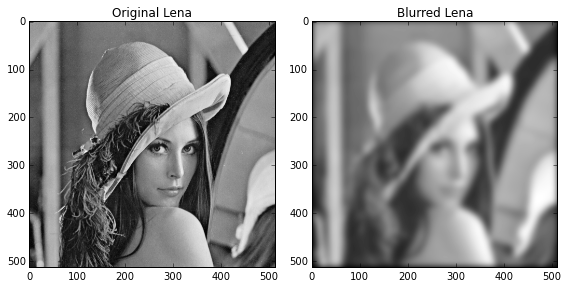

In [1]:
import numpy as np
import scipy
from scipy import misc
import pylab as pl
from scipy.sparse.linalg import LinearOperator
%matplotlib inline

lena = misc.lena()
n=262144
size = 512
a=0.01

def multilevel_matvec(x):
    global size
    i = np.append(np.arange(size),np.arange(-1*(size-1), 0))
    j = np.append(np.arange(size),np.arange(-1*(size-1), 0))
    i, j = np.meshgrid(i, j)
    global a
    T=(a/np.pi)*np.exp(-a*(i**2+j**2))
    N = len(T)
    x = x.reshape(size,-1)
    result = np.zeros((N, N))
    result[:size, :size] = x
    return (np.fft.ifft2(np.fft.fft2(T)* np.fft.fft2(result))[:size,:size].reshape(-1,1)).real


L = scipy.sparse.linalg.LinearOperator((n,n), matvec=multilevel_matvec,dtype=float)
#blurred=multilevel_matvec(lena)
blurred = L.dot(lena.reshape(-1))
blurred=blurred.astype(np.float).reshape(512,-1)
fig, ax = pl.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(lena, cmap='gray')
ax[0].set_title('Original Lena')
ax[1].imshow(blurred, cmap='gray')
ax[1].set_title('Blurred Lena')
fig.tight_layout()

In [2]:
itr = 0
ilist = []
normlist =[]
lena = lena.reshape(-1)
def callback(xk):
    global itr, lena
    itr += 1
    ilist.append(itr)
    normlist.append(np.linalg.norm(lena - xk))


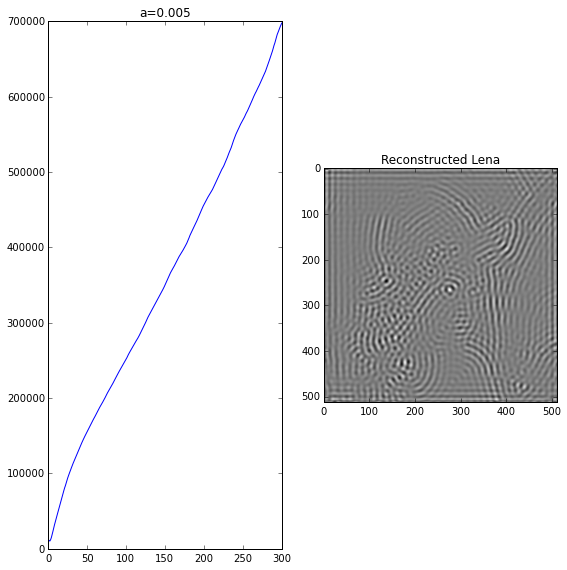

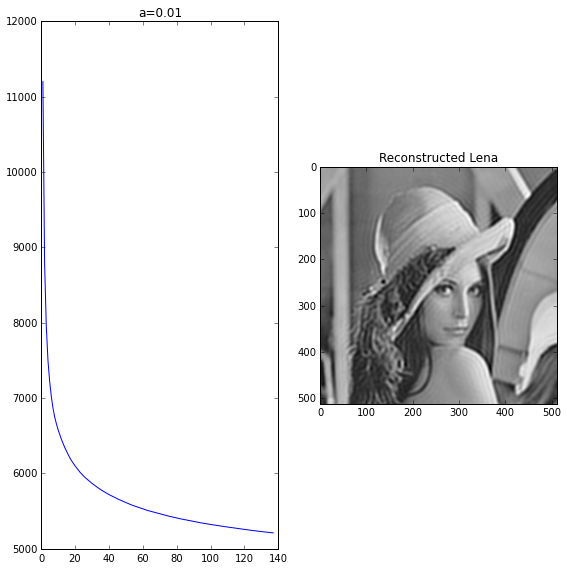

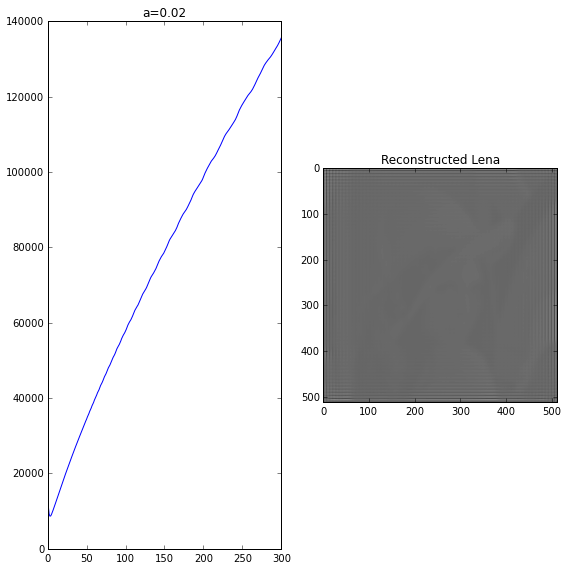

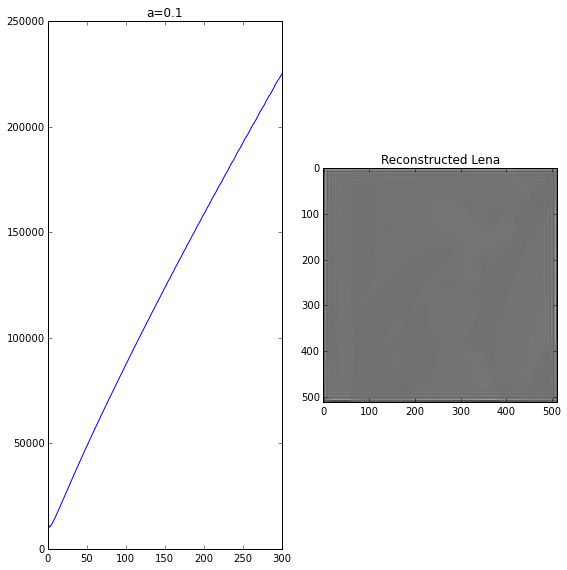

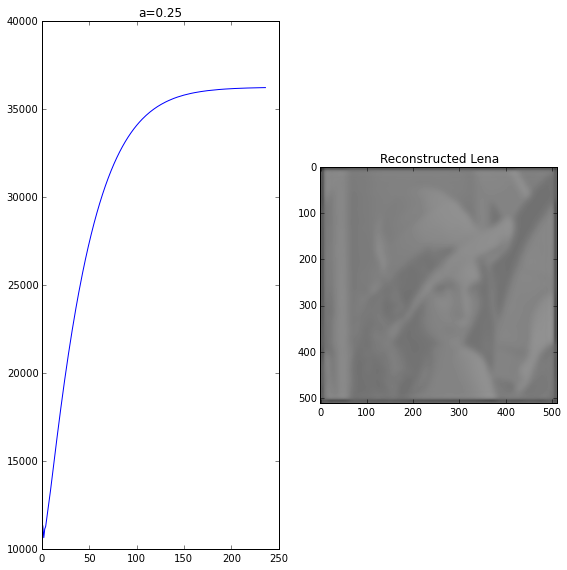

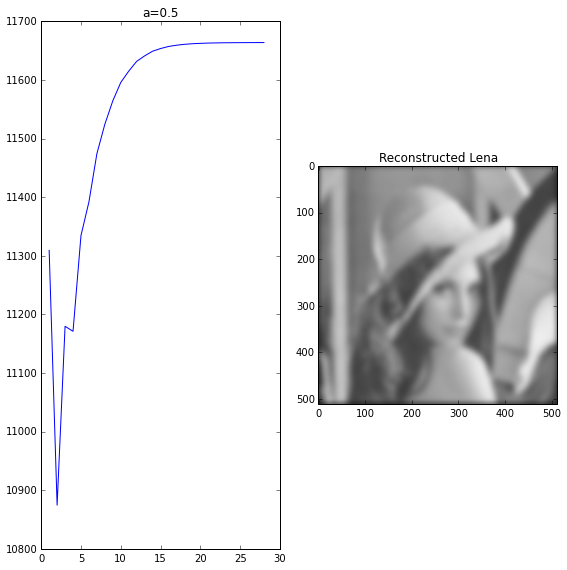

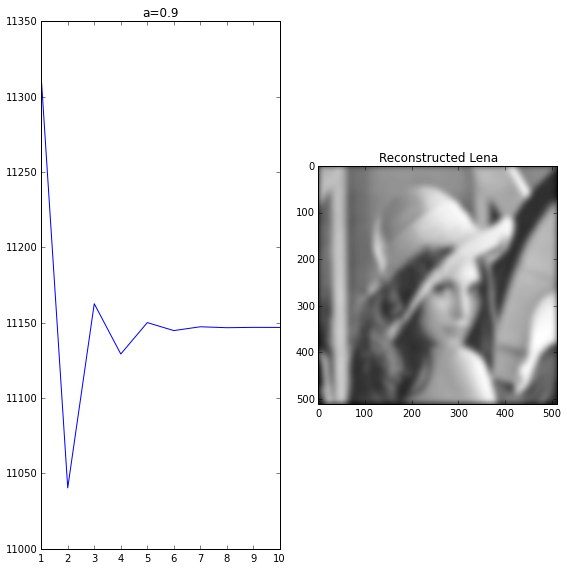

In [3]:
alist= [0.005, 0.01, 0.02, 0.1, 0.25, 0.5, 0.9]
for i in alist:
    a = i
    itr = 0
    ilist = []
    normlist = []
    fig, ax = pl.subplots(1, 2, figsize=(8, 8))
    x, s = scipy.sparse.linalg.cg(L, blurred.reshape(-1), maxiter=300, callback=callback)
    x = x.astype(np.float).reshape(512,-1)
    ax[0].plot(ilist,normlist)
    ax[0].set_title('a=%s'%(a))
    ax[1].imshow(x, cmap='gray')
    ax[1].set_title('Reconstructed Lena')
    fig.tight_layout()
    pl.show()

For almost all 'a' problem becoms ill-posed and requires some regularization techniques. However for homework you gave us a 'good a'. Thanks) 

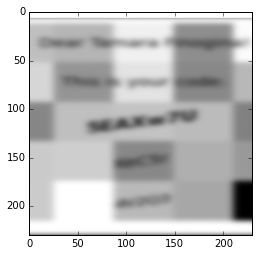

In [44]:
from PIL import Image
im = Image.open("./Figs/Tamara Finogina.png").convert('RGB') 
img = np.array(im)

pl.imshow(img, cmap='gray')
im = img[:,:,0]

In [61]:
import random

size = 230
i = np.append(np.arange(size),np.arange(-1*(size-1), 0))
j = np.append(np.arange(size),np.arange(-1*(size-1), 0))
i, j = np.meshgrid(i, j)
a = 1.0/15.0
T=(a/np.pi)*np.exp(-a*(i**2+j**2))
N = len(T)
lm = 0.0786
def matvec_tykhonov(x, H2, lm):
    x = x.reshape(size,-1)
    result = np.zeros((N, N))
    result[:size, :size] = x
    H2[0, 0] += lm
    res = ((np.fft.ifft2(np.fft.fft2(H2) * np.fft.fft2(result)))[:size, :size]).real
    res[0, 0] += lm
    return res.reshape(-1,1)

<52900x52900 _CustomLinearOperator with dtype=float64>


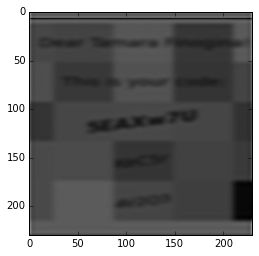

In [62]:
n = im.reshape(-1).shape[0]
L = scipy.sparse.linalg.LinearOperator((n,n), matvec=lambda x: matvec_tykhonov(x, T, lm), dtype=float)
print L
x, s = scipy.sparse.linalg.cg(L, im.copy().reshape(-1), maxiter=100, tol=1e-9)
x = x.astype(np.float).reshape(size,-1)
pl.imshow(x, cmap='gray')
pl.show()

## §